In [ ]:
%pip install geoplot

In [ ]:
%pip install geopandas

In [ ]:
%pip install seaborn

In [ ]:
%pip install cartopy

In [ ]:
%pip install shapely==2.0.7 

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import matplotlib.colors as mcolors
import seaborn as sns
from shapely.geometry import Polygon

In [2]:
gdf = gpd.read_file('cb_2018_us_state')

Set up the value column that will be visualised

In [3]:
df = pd.read_csv('car_prices_processed.csv')
count_by_state = df['state'].value_counts().sort_values(ascending=False)
small_df = pd.DataFrame({'state':count_by_state.index, 'cars':count_by_state.values})
small_df['cars'] = small_df['cars'].astype(int)
small_df['state'] = small_df['state'].astype(str)
small_df['state'] = small_df['state'].str.upper()
gdf['STUSPS'] = gdf['STUSPS'].astype(str)

38

* Merge the visualised column to gdf
* Each state without a value to plot will get 1

In [4]:
gdf = gdf.merge(small_df, left_on='STUSPS', right_on='state', how='left')
gdf['cars'] = gdf['cars'].replace(np.nan, 1)
gdf['cars'] = gdf['cars'].astype(int)

* Delete irrelevant states

In [5]:
gdf = gdf.drop([13, 37, 38, 44, 45])

* Create a new column of assigned colors & return full frame

In [6]:
def makeColorColumn(gdf, variable, vmin, vmax, color_map):
    norm = mcolors.LogNorm(vmin = vmin, vmax = vmax, clip = True)
    mapper = plt.cm.ScalarMappable(norm = norm, cmap = color_map)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf

* Make a column for value_determined_color in gdf
* Choose the continuous colorscale

In [7]:
variable = gdf['cars'].values
vmin, vmax = variable.min(), variable.max()
colormap = plt.cm.PuBuGn
gdf = makeColorColumn(gdf, 'cars', vmin, vmax, colormap)

In [8]:
visframe = gdf.to_crs(crs=2163)

<Axes: >

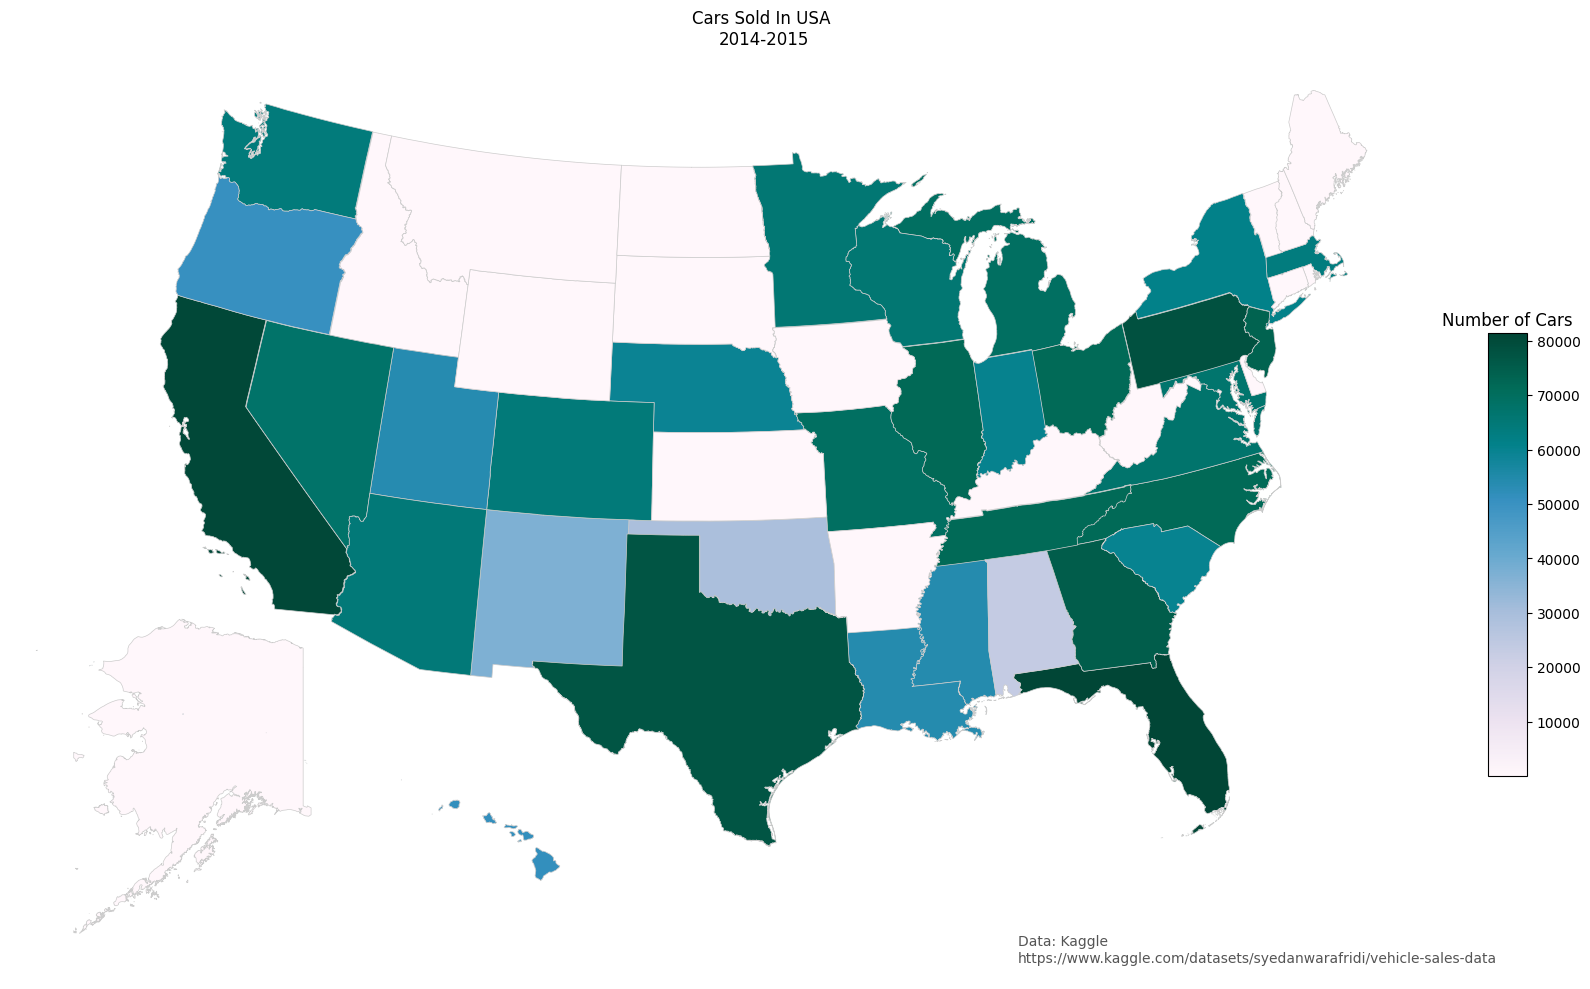

In [9]:
fig, ax = plt.subplots(1, figsize=(19.20, 10.80))
ax.axis('off')
ax.set_title('Cars Sold In USA \n2014-2015')
fig = ax.get_figure()
# [l,b,w,h] l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = fig.add_axes([0.89, 0.21, 0.02, 0.41])
cbax.set_title('Number of Cars')
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
fig.colorbar(sm, cax=cbax)
ax.annotate("Data: Kaggle\nhttps://www.kaggle.com/datasets/syedanwarafridi/vehicle-sales-data", 
            xy=(0.53, 0.025), xycoords='figure fraction', color='#555555')

# create map
for row in visframe.itertuples():
    if row.STUSPS not in ['AK','HI']:
        vf = visframe[visframe.STUSPS == row.STUSPS]
        c = gdf[gdf.STUSPS == row.STUSPS][0:1].value_determined_color.item()
        vf.plot(color = c, linewidth = 0.5, ax = ax, edgecolor = '0.8')


# add Alaska & Hawaii
akax = fig.add_axes([0.04, 0.05, 0.35, 0.32])   
akax.axis('off')
ak_polygon = Polygon([(-170,50), (-170,72), (-140, 72), (-140,50)])
alaska_gdf = gdf[gdf.STUSPS=='AK']
alaska_gdf.clip(ak_polygon).plot(color=gdf[gdf.STUSPS=='AK'].value_determined_color, linewidth=0.5,ax=akax, edgecolor='0.8')

hiax = fig.add_axes([0.12, 0.07, 0.3, 0.3])   
hiax.axis('off')
hi_polygon = Polygon([(-178.443593, 18.86546), (-178.443593, 28.517269), (-154.755792, 28.517269), (-154.755792, 18.86546)])
hawaii_gdf = gdf[gdf.STUSPS=='HI']
hawaii_gdf.clip(hi_polygon).plot(color=hawaii_gdf['value_determined_color'], linewidth=0.5,ax=hiax, edgecolor='0.8')

In [ ]:
fig.savefig('car_sales_by_state_2014_2015.png',dpi=1200, bbox_inches="tight")